# Mi primer red neuronal


En este curso, construiremos nuestra primera red neuronal utilizando la biblioteca [micrograd](https://github.com/karpathy/micrograd/tree/master). Micrograd es una biblioteca sencilla y fácil de entender, especializada en el cálculo automático de gradientes. Para dominarla mejor, puedes ver el [vídeo de introducción](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4s&ab_channel=AndrejKarpathy) de Andrej Karpathy (en inglés).
Este cuaderno también se inspira en el cuaderno proporcionado en el repositorio de micrograd.


## Construcción de una red neuronal con micrograd


In [1]:
#!pip install micrograd # uncomment to install micrograd
import random
import numpy as np 
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

Para construir una red neuronal, primero necesitamos un problema que resolver. Para ello, utilizamos la función [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) de scikit-learn, que permite generar un conjunto de datos.
Para simplificar el cálculo de la pérdida (*loss*) en los pasos siguientes, reemplazamos las clases $0$ y $1$ por las clases $-1$ y $1$.


### Inicialización del conjunto de datos


Les données d'entrée sont de la forme :  [-0.81882941  0.05879006]


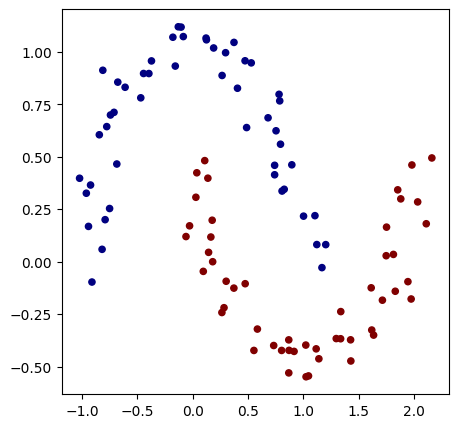

In [2]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) # 100 éléments et un bruit Gaussien d'écart type 0.1 ajouté sur les données 

print("Les données d'entrée sont de la forme : ",X[1])

y = y*2 - 1 # Pour avoir y=-1 ou y=1 (au lieu de 0 et 1)

# Visualisation des données en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Creación de la red neuronal


Ahora, inicializaremos nuestra red neuronal. Esta recibe $2$ valores de entrada y debe producir una etiqueta $-1$ o $1$.
La red que construiremos tiene $2$ capas ocultas, cada una con $16$ neuronas. Cada neurona funciona como una regresión logística, lo que convierte a nuestra red en un ensamblaje no lineal de múltiples regresiones logísticas.

A continuación, se muestra un esquema de la arquitectura de esta red:

![Mlp](./images/Mlp.png)


In [3]:
# Initialisation du modèle 
model = MLP(2, [16, 16, 1]) # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Nombre de paramètres 337


### Descenso de gradiente estocástico (SGD)


Antes de continuar, hablemos sobre el descenso de gradiente estocástico (SGD).
Para aplicar el algoritmo de descenso de gradiente en un conjunto de datos de tamaño $N$, en teoría sería necesario calcular la pérdida y el gradiente en cada elemento antes de actualizar los pesos. Este método garantiza una disminución de la pérdida en cada iteración, pero es muy costoso para conjuntos de datos donde $N$ es grande (a menudo $N > 10^6$). Además, sería necesario almacenar los gradientes de todos los $N$ elementos en memoria, lo cual es imposible para grandes conjuntos de datos.

Para resolver este problema, utilizamos *mini-batches*, que son grupos de muestras del conjunto de datos. La optimización se realiza como en el descenso de gradiente clásico, pero la actualización de los pesos se realiza en cada *mini-batch* (por lo tanto, con mayor frecuencia). Esto hace que el proceso de optimización sea más rápido y permite manejar grandes cantidades de datos. El tamaño de un *mini-batch* se denomina *batch size* y su valor suele ser $16$, $32$ o $64$.
Para obtener más información sobre el descenso de gradiente estocástico, consulta [Wikipedia](https://es.wikipedia.org/wiki/Descenso_por_gradiente_estoc%C3%A1stico) o este [artículo](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31).

Definamos en Python una función para recuperar *batch_size* elementos aleatorios de nuestro conjunto de datos.


In [4]:
def get_batch(batch_size=64):
  ri = np.random.permutation(X.shape[0])[:batch_size]
  Xb, labels = X[ri], y[ri]
  #inputs = [list(map(Value, xrow)) for xrow in Xb] # OLD
  # Conversion des inputs en Value pour pouvoir utiliser micrograd
  inputs = [list([Value(xrow[0]),Value(xrow[1])]) for xrow in Xb]
  return inputs,labels

### Función de pérdida


Para entrenar nuestra red neuronal, debemos definir una función de pérdida (*loss*). En nuestro caso, tenemos dos clases y queremos maximizar el margen entre los ejemplos que pertenecen a clases diferentes. A diferencia de la pérdida de log-verosimilitud negativa utilizada previamente, buscamos maximizar esta diferencia, lo que hace que nuestro método sea más robusto ante nuevos elementos.

Utilizamos la *pérdida de margen máximo* (*max-margin loss*), definida por:
$\text{loss} = \max(0, 1 - y_i \cdot \text{score}_i)$


In [5]:
def loss_function(scores,labels):
  # La fonction .relu() prend le maximum entre 0 et la valeur de 1 - yi*scorei
  losses = [(1 - yi*scorei).relu() for yi, scorei in zip(labels, scores)]
  # On divise le loss par le nombre d'éléments du mini-batch
  data_loss = sum(losses) * (1.0 / len(losses))
  return data_loss

### Entrenamiento del modelo


Ahora que tenemos los elementos clave del entrenamiento, es hora de definir nuestro bucle de entrenamiento.


In [6]:
# Définissons nos hyper-paramètres d'entraînement 
batch_size=128
iteration=50

Ahora podemos iniciar el entrenamiento de nuestro modelo:


In [7]:
for k in range(iteration):
    
  # On récupère notre mini-batch random
  inputs,labels=get_batch(batch_size=batch_size)

  # On fait appel au modèle pour calculer les scores Y
  scores = list(map(model, inputs))
  
  # On calcule le loss
  loss=loss_function(scores,labels)


  accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
  accuracy=sum(accuracy) / len(accuracy)
  
  # Remise à zéro de valeurs de gradients avant de les calculer
  model.zero_grad() 
  # Calcul des gradients grâce à l'autograd de micrograd
  loss.backward() 
  
  # Mise à jour des poids avec les gradients calculés (SGD)
  learning_rate = 1.0 - 0.9*k/100 # On diminue le learning rate au fur et à mesure de l'entraînement
  for p in model.parameters():
      p.data -= learning_rate * p.grad
  
  if k % 1 == 0:
      print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.8862514464368221, accuracy 50.0%
step 1 loss 1.7136790633950052, accuracy 81.0%
step 2 loss 0.733396126728699, accuracy 77.0%
step 3 loss 0.7615247055858604, accuracy 82.0%
step 4 loss 0.35978083334534205, accuracy 84.0%
step 5 loss 0.3039360355411295, accuracy 86.0%
step 6 loss 0.2716587340549048, accuracy 89.0%
step 7 loss 0.25896576803013205, accuracy 91.0%
step 8 loss 0.2468445503533517, accuracy 91.0%
step 9 loss 0.26038987927745966, accuracy 91.0%
step 10 loss 0.23569710047306525, accuracy 91.0%
step 11 loss 0.2403768930229477, accuracy 92.0%
step 12 loss 0.20603128479123115, accuracy 91.0%
step 13 loss 0.22061157796029193, accuracy 93.0%
step 14 loss 0.19010711228374735, accuracy 92.0%
step 15 loss 0.21687609382796402, accuracy 93.0%
step 16 loss 0.18642445342175254, accuracy 92.0%
step 17 loss 0.2064478196088666, accuracy 92.0%
step 18 loss 0.15299793102189654, accuracy 94.0%
step 19 loss 0.18164592701596197, accuracy 93.0%
step 20 loss 0.15209012673698674, accura

Como pueden observar, la *pérdida* (*loss*) no disminuye sistemáticamente en cada paso del entrenamiento. Esto se explica por el descenso de gradiente estocástico: el hecho de no considerar todo el conjunto de datos en cada iteración introduce un componente aleatorio. Sin embargo, la *pérdida* disminuye en promedio durante el entrenamiento, lo que permite obtener un modelo robusto más rápidamente.


(-1.548639298268643, 1.951360701731357)

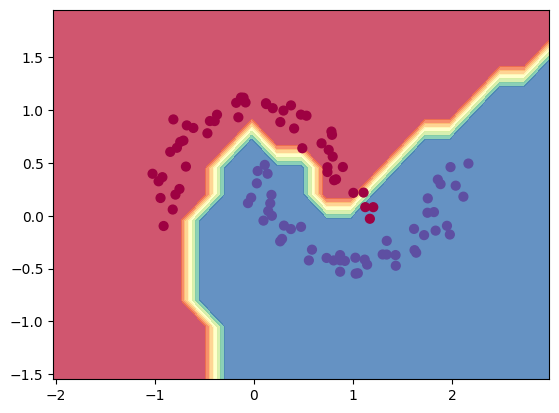

In [8]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())